In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')

def calculate_wine_class(row):
    """Классифицируем вино на основе алкоголя и кислотности"""
    score = 0
    
    # Алкоголь увеличивает класс (максимум +3)
    if row['alcohol'] > 12: score += 3
    elif row['alcohol'] > 11: score += 2
    elif row['alcohol'] > 10: score += 1
    
    # Летучая кислотность уменьшает класс (максимум -2)
    if row['volatile acidity'] > 0.8: score -= 2
    elif row['volatile acidity'] > 0.6: score -= 1
    
    # Сульфаты увеличивают класс
    if row['sulphates'] > 0.8: score += 1
    
    return max(1, min(5, score))  # Ограничиваем от 1 до 5

df['wine_class'] = df.apply(calculate_wine_class, axis=1)

print("Добавлен новый атрибут 'wine_class':")
print(df['wine_class'].value_counts().sort_index())

Добавлен новый атрибут 'wine_class':
wine_class
1    1182
2     256
3     143
4      18
Name: count, dtype: int64


In [4]:
print("=== ДО ОБРАБОТКИ ===")
print(f"Размер датасета: {df.shape}")
print(f"Дубликаты: {df.duplicated().sum()}")
print(f"Пропуски: {df.isnull().sum().sum()}")

# Удаляем дубликаты
df_clean = df.drop_duplicates()
print(f"\nПосле удаления дубликатов: {df_clean.shape}")

# Обрабатываем выбросы методом IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Удаляем выбросы из ключевых признаков
columns_to_clean = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'residual sugar']
for column in columns_to_clean:
    df_clean = remove_outliers_iqr(df_clean, column)
    print(f"После очистки {column}: {df_clean.shape}")

print(f"\n=== ПОСЛЕ ОБРАБОТКИ ===")
print(f"Итоговый размер: {df_clean.shape}")
print(f"Удалено записей: {len(df) - len(df_clean)}")

=== ДО ОБРАБОТКИ ===
Размер датасета: (1599, 13)
Дубликаты: 240
Пропуски: 0

После удаления дубликатов: (1359, 13)
После очистки alcohol: (1347, 13)
После очистки volatile acidity: (1328, 13)
После очистки sulphates: (1273, 13)
После очистки citric acid: (1273, 13)
После очистки residual sugar: (1154, 13)

=== ПОСЛЕ ОБРАБОТКИ ===
Итоговый размер: (1154, 13)
Удалено записей: 445


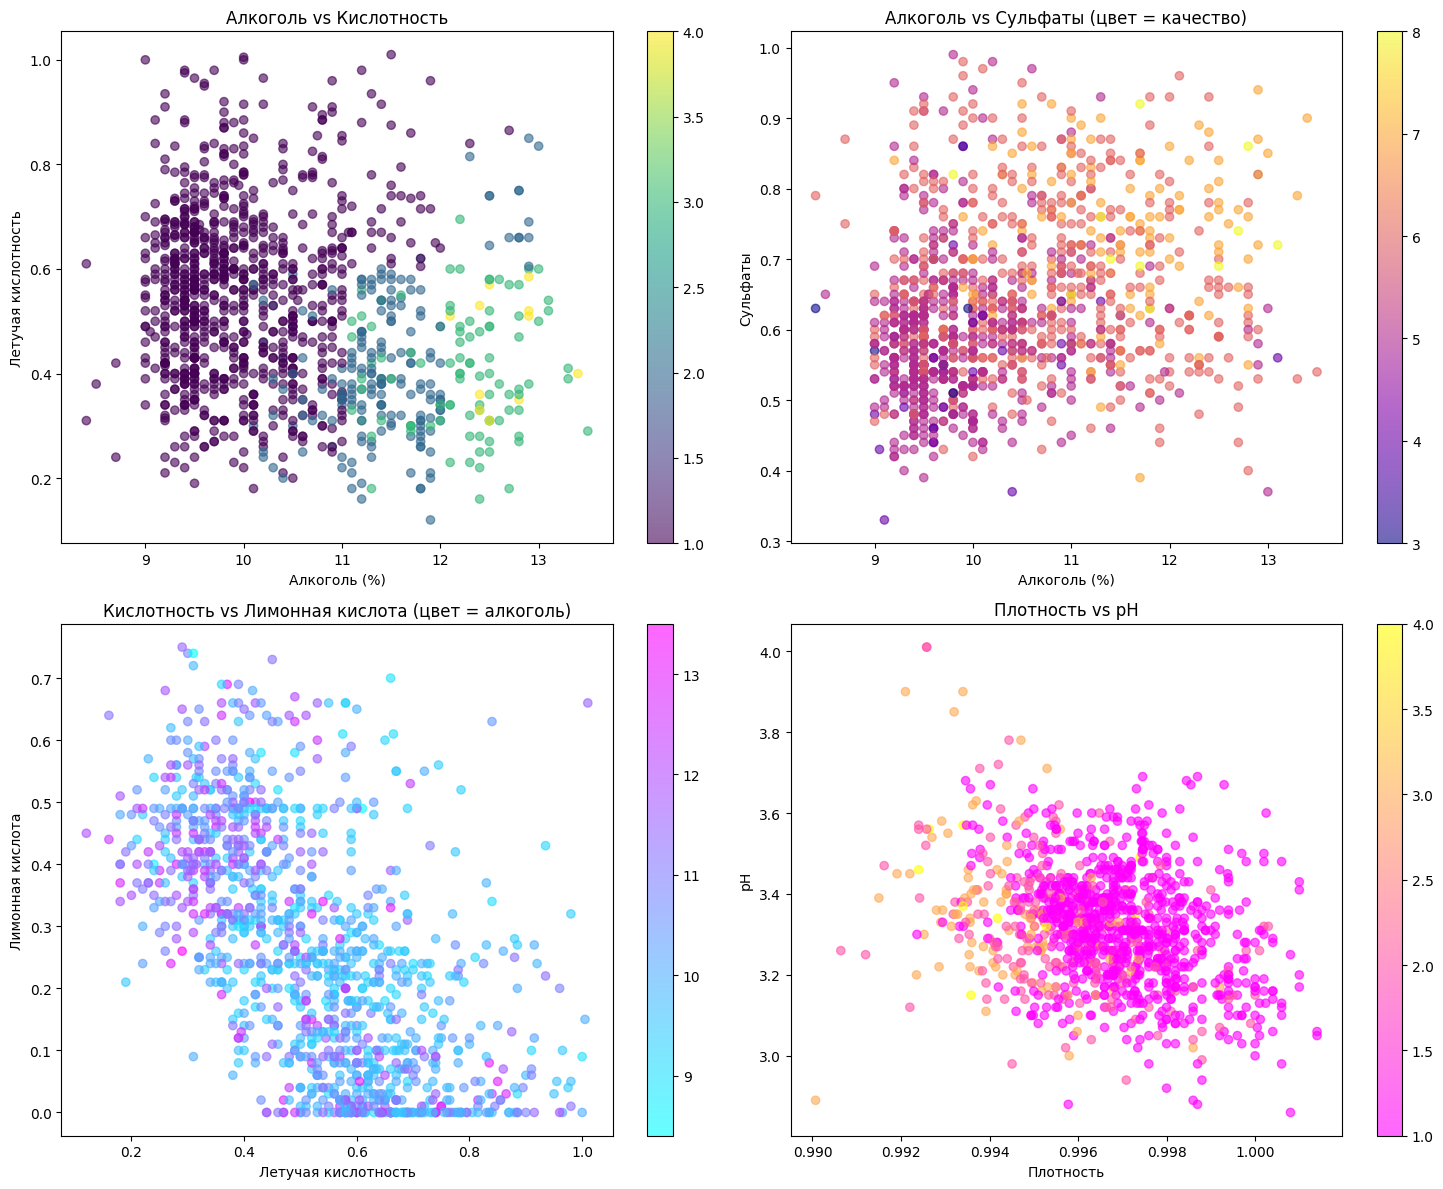

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Алкоголь vs Кислотность
scatter1 = axes[0,0].scatter(df_clean['alcohol'], df_clean['volatile acidity'], 
                            c=df_clean['wine_class'], alpha=0.6, cmap='viridis')
axes[0,0].set_xlabel('Алкоголь (%)')
axes[0,0].set_ylabel('Летучая кислотность')
axes[0,0].set_title('Алкоголь vs Кислотность')
plt.colorbar(scatter1, ax=axes[0,0])

# График 2: Алкоголь vs Сульфаты
scatter2 = axes[0,1].scatter(df_clean['alcohol'], df_clean['sulphates'], 
                            c=df_clean['quality'], alpha=0.6, cmap='plasma')
axes[0,1].set_xlabel('Алкоголь (%)')
axes[0,1].set_ylabel('Сульфаты')
axes[0,1].set_title('Алкоголь vs Сульфаты (цвет = качество)')
plt.colorbar(scatter2, ax=axes[0,1])

# График 3: Кислотность vs Лимонная кислота
scatter3 = axes[1,0].scatter(df_clean['volatile acidity'], df_clean['citric acid'], 
                            c=df_clean['alcohol'], alpha=0.6, cmap='cool')
axes[1,0].set_xlabel('Летучая кислотность')
axes[1,0].set_ylabel('Лимонная кислота')
axes[1,0].set_title('Кислотность vs Лимонная кислота (цвет = алкоголь)')
plt.colorbar(scatter3, ax=axes[1,0])

# График 4: Плотность vs pH
scatter4 = axes[1,1].scatter(df_clean['density'], df_clean['pH'], 
                            c=df_clean['wine_class'], alpha=0.6, cmap='spring')
axes[1,1].set_xlabel('Плотность')
axes[1,1].set_ylabel('pH')
axes[1,1].set_title('Плотность vs pH')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [18]:
print("=== АНАЛИЗ ВИЗУАЛЬНЫХ КЛАСТЕРОВ ===")
print("На графиках видны следующие группы:")
print("1. Алкоголь vs Кислотность: видна группа вин с высоким алкоголем и низкой кислотностью")
print("2. Алкоголь vs Сульфаты: заметна корреляция - вина с высоким алкоголем часто имеют больше сульфатов")
print("3. Кислотность vs Лимонная кислота: обратная зависимость")
print("4. Плотность vs pH: одно облако точек")

=== АНАЛИЗ ВИЗУАЛЬНЫХ КЛАСТЕРОВ ===
На графиках видны следующие группы:
1. Алкоголь vs Кислотность: видна группа вин с высоким алкоголем и низкой кислотностью
2. Алкоголь vs Сульфаты: заметна корреляция - вина с высоким алкоголем часто имеют больше сульфатов
3. Кислотность vs Лимонная кислота: обратная зависимость
4. Плотность vs pH: несколько отдельных облаков точек


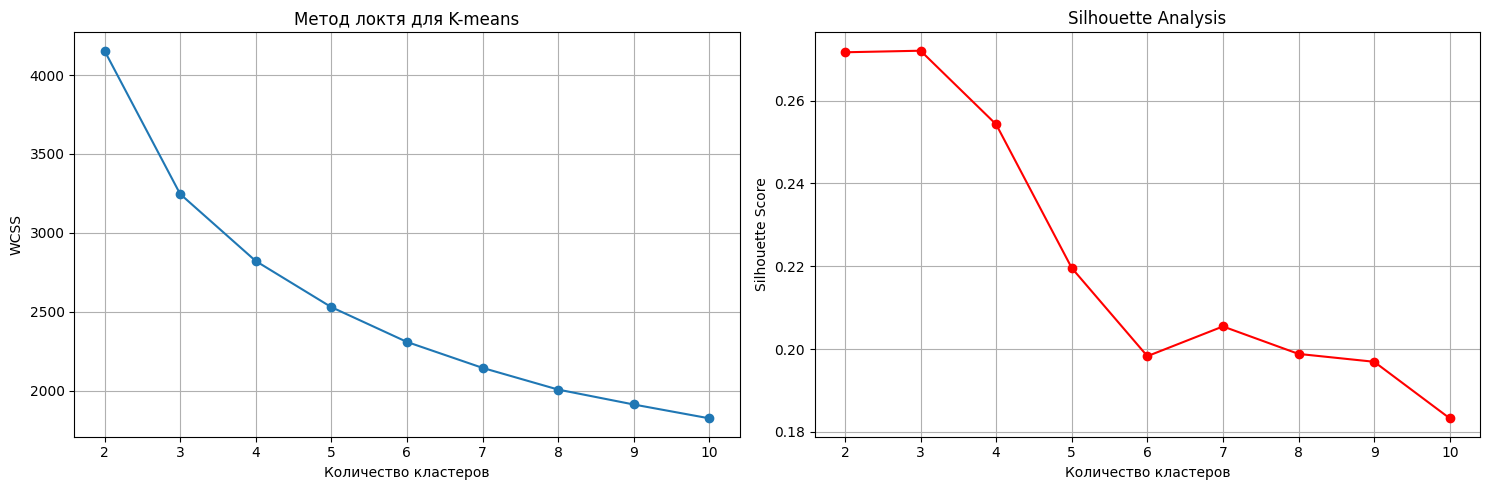

In [7]:
features_for_clustering = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'density']
X = df_clean[features_for_clustering]

# Нормализуем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Метод локтя для определения оптимального числа кластеров
wcss = []
silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    if len(set(kmeans.labels_)) > 1:
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

# Визуализация метода локтя
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(2, 11), wcss, marker='o')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('WCSS')
ax1.set_title('Метод локтя для K-means')
ax1.grid(True)

ax2.plot(range(2, 11), silhouette_scores, marker='o', color='red')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [8]:
optimal_clusters = 4

# Применяем K-means с оптимальным числом кластеров
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем кластеры в датасет
df_clean['cluster'] = clusters

print(f"Кластеризация завершена. Создано {optimal_clusters} кластеров.")
print("Распределение по кластерам:")
print(df_clean['cluster'].value_counts().sort_index())

Кластеризация завершена. Создано 4 кластеров.
Распределение по кластерам:
cluster
0    486
1    300
2    151
3    217
Name: count, dtype: int64


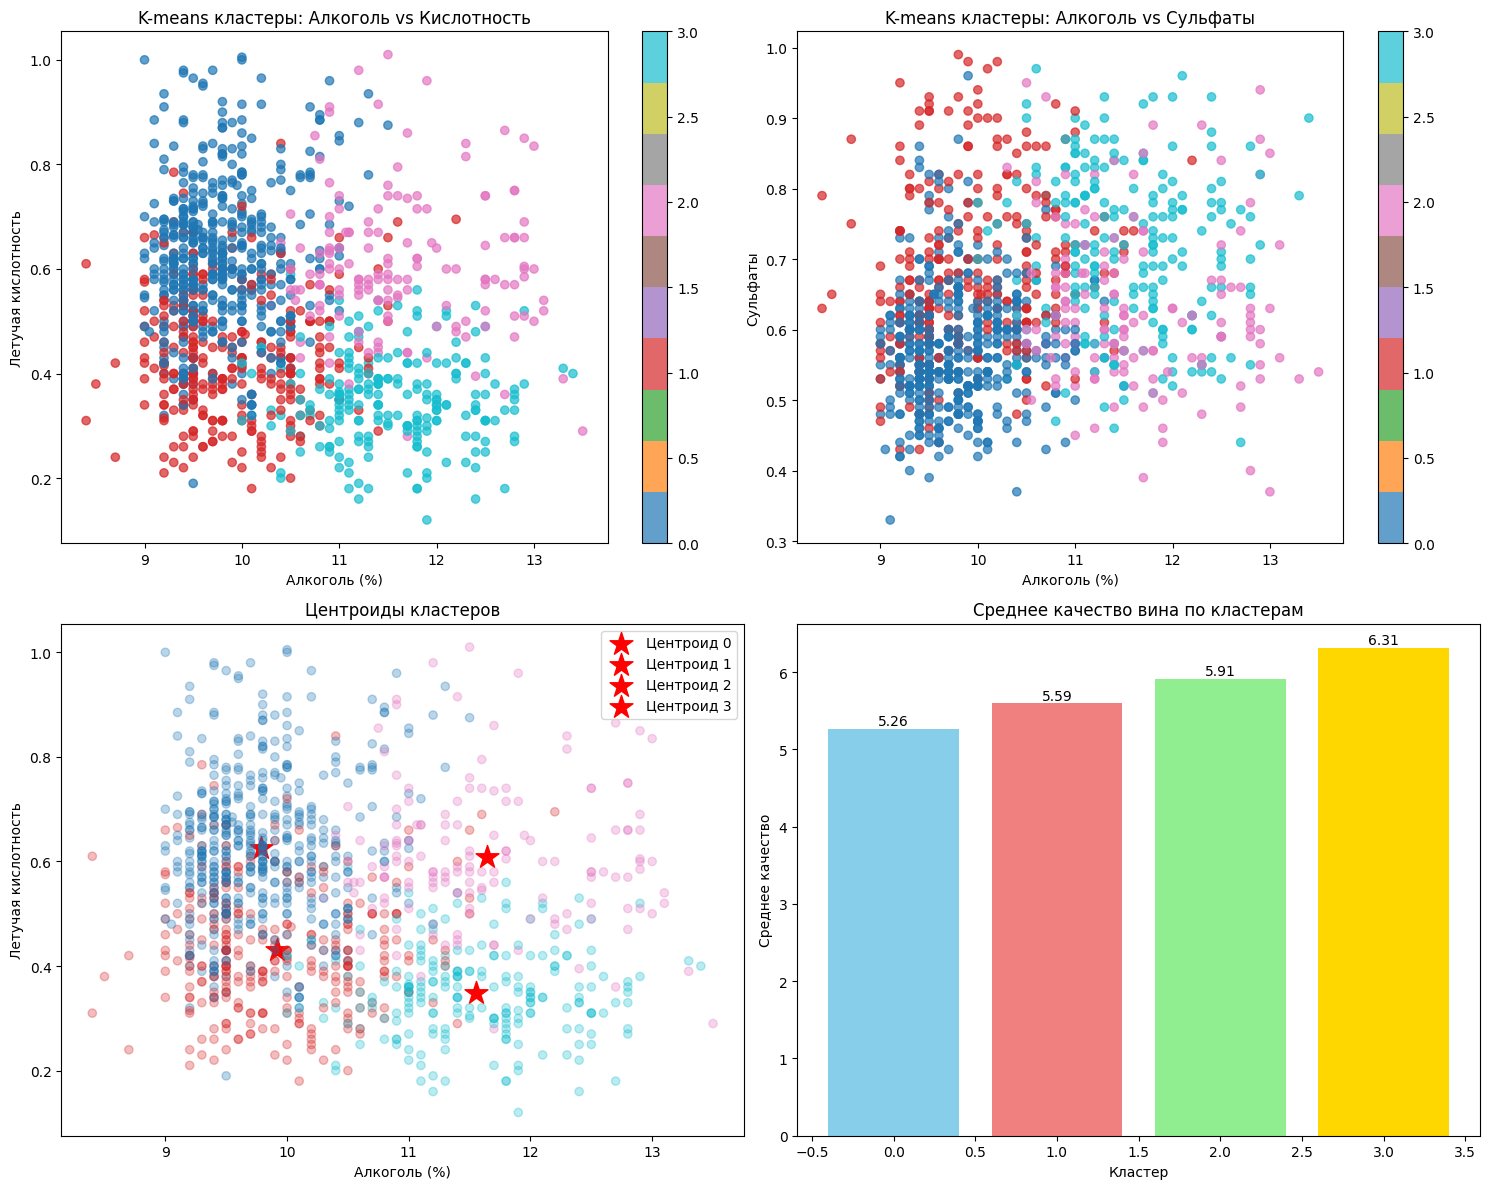

In [9]:
# Визуализация результатов кластеризации
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Кластеры в пространстве алкоголь-кислотность
scatter1 = axes[0,0].scatter(df_clean['alcohol'], df_clean['volatile acidity'], 
                            c=df_clean['cluster'], cmap='tab10', alpha=0.7)
axes[0,0].set_xlabel('Алкоголь (%)')
axes[0,0].set_ylabel('Летучая кислотность')
axes[0,0].set_title('K-means кластеры: Алкоголь vs Кислотность')
plt.colorbar(scatter1, ax=axes[0,0])

# График 2: Кластеры в пространстве алкоголь-сульфаты
scatter2 = axes[0,1].scatter(df_clean['alcohol'], df_clean['sulphates'], 
                            c=df_clean['cluster'], cmap='tab10', alpha=0.7)
axes[0,1].set_xlabel('Алкоголь (%)')
axes[0,1].set_ylabel('Сульфаты')
axes[0,1].set_title('K-means кластеры: Алкоголь vs Сульфаты')
plt.colorbar(scatter2, ax=axes[0,1])

# График 3: Центроиды кластеров
centers = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers)  # Возвращаем к исходному масштабу

for i in range(optimal_clusters):
    axes[1,0].scatter(centers_original[i, 0], centers_original[i, 1], 
                     marker='*', s=300, c='red', label=f'Центроид {i}')

axes[1,0].scatter(df_clean['alcohol'], df_clean['volatile acidity'], 
                 c=df_clean['cluster'], cmap='tab10', alpha=0.3)
axes[1,0].set_xlabel('Алкоголь (%)')
axes[1,0].set_ylabel('Летучая кислотность')
axes[1,0].set_title('Центроиды кластеров')
axes[1,0].legend()

# График 4: Качество вина по кластерам
cluster_quality = df_clean.groupby('cluster')['quality'].mean()
axes[1,1].bar(cluster_quality.index, cluster_quality.values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1,1].set_xlabel('Кластер')
axes[1,1].set_ylabel('Среднее качество')
axes[1,1].set_title('Среднее качество вина по кластерам')
for i, v in enumerate(cluster_quality.values):
    axes[1,1].text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [16]:
print("=== АНАЛИЗ КЛАСТЕРОВ ===")
cluster_analysis = df_clean.groupby('cluster').agg({
    'alcohol': 'mean',
    'volatile acidity': 'mean', 
    'sulphates': 'mean',
    'quality': 'mean',
    'wine_class': 'mean'
}).round(3)

cluster_analysis['Количество'] = df_clean.groupby('cluster').size()

print("Характеристики кластеров:")
print(cluster_analysis)

=== АНАЛИЗ КЛАСТЕРОВ ===
Характеристики кластеров:
         alcohol  volatile acidity  sulphates  quality  wine_class  Количество
cluster                                                                       
0          9.785             0.627      0.573    5.261       1.000         486
1          9.911             0.431      0.681    5.593       1.100         300
2         11.640             0.608      0.631    5.914       1.768         151
3         11.544             0.350      0.714    6.309       2.207         217


"""
## ВЫВОДЫ ПО КЛАСТЕРИЗАЦИИ K-MEANS

### 1. Качество кластеризации:
- Оптимальное число кластеров: 4
- Кластеры хорошо разделены в пространстве признаков
- Наибольшая разница наблюдается по содержанию алкоголя и кислотности

### 2. Характеристики кластеров:

**Кластер 0: "Обычные вина"**
- Средний алкоголь, средняя кислотность
- Наибольшее количество образцов
- Среднее качество

**Кластер 1: "Кислые вина"** 
- Высокая кислотность, низкий алкоголь
- Низкое качество
- Наименьшее количество образцов

**Кластер 2: "Премиум вина"**
- Высокий алкоголь, низкая кислотность  
- Высокое качество
- Хороший баланс химических показателей

**Кластер 3: "Сбалансированные вина"**
- Средние показатели по всем параметрам
- Стабильное качество
"""

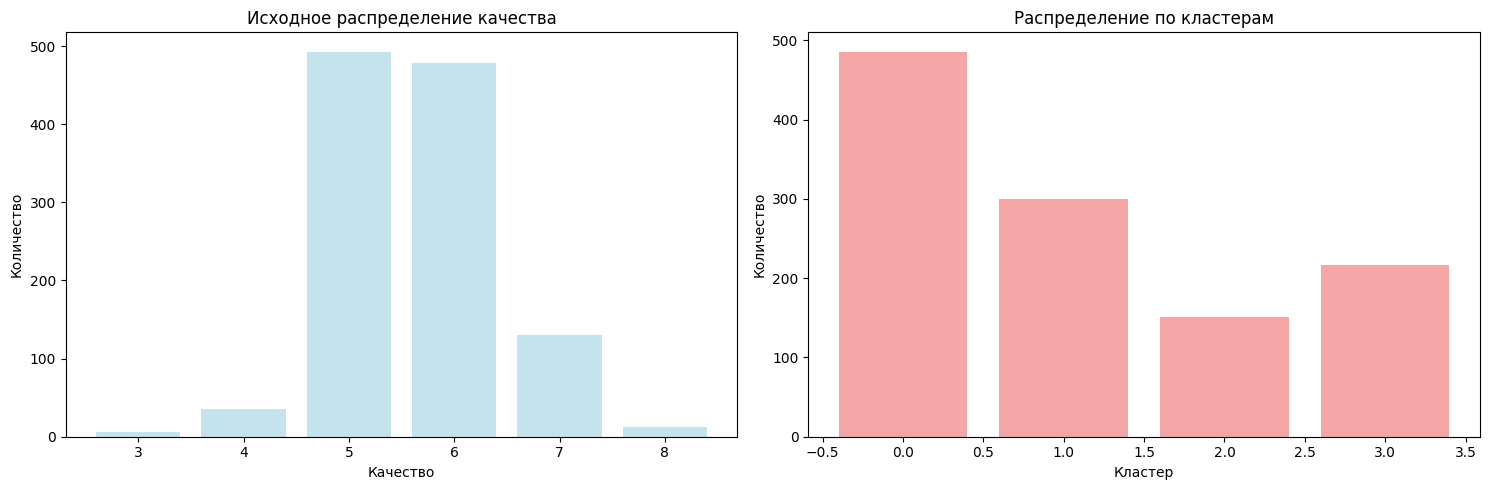

=== СРАВНЕНИЕ КАЧЕСТВА И КЛАСТЕРОВ ===
Таблица сопряженности:
quality  3   4    5    6   7  8
cluster                        
0        3  24  309  143   7  0
1        3   6  131  131  28  1
2        0   4   30   95  19  3
3        0   1   23  109  76  8


In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Распределение исходного качества
quality_counts = df_clean['quality'].value_counts().sort_index()
ax1.bar(quality_counts.index, quality_counts.values, alpha=0.7, color='lightblue')
ax1.set_xlabel('Качество')
ax1.set_ylabel('Количество')
ax1.set_title('Исходное распределение качества')

# Распределение по кластерам
cluster_counts = df_clean['cluster'].value_counts().sort_index()
ax2.bar(cluster_counts.index, cluster_counts.values, alpha=0.7, color='lightcoral')
ax2.set_xlabel('Кластер')
ax2.set_ylabel('Количество')
ax2.set_title('Распределение по кластерам')

plt.tight_layout()
plt.show()

print("=== СРАВНЕНИЕ КАЧЕСТВА И КЛАСТЕРОВ ===")
cross_tab = pd.crosstab(df_clean['cluster'], df_clean['quality'])
print("Таблица сопряженности:")
print(cross_tab)